# Задание 2. Изучение свойств и харктеристик валютных ПФИ и инструментов денежного рынка
> выполнил Литвинов А. А., гр. МФИН211

## 1. Загрузка библиотек


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

## 2. Полезные функции


In [2]:
# создание массива процентных ставок
def rates_y(term, s_t, f, start_r, step_r):
    end = int(term * f)
    rates = [start_r + step_r * i for i in range(0, end)]
    return OrderedDict(
        zip([i for i in np.arange(s_t, term * f, 1 / freq)], rates))


# расчет форвардных курсов
def forward_ex_rate(rates_A, rates_B, ex_rate, freq):
    n = len(rates_A)
    l = []
    for key in rates_A:
        l.append(ex_rate * (((1 + rates_B[key] / freq) /
                             (1 + rates_A[key] / freq))**(key * freq)))
    #l.append(ex_rate*(np.exp((rates_B[key]-rates_A[key])*key)))
    return OrderedDict(zip(rates_A.keys(), l))


In [3]:
step_rate = 0.000  ## шаг изменения процентных ставок (везде принимаем равным 0)
freq = 2  ##частота выплаты купона и начисления процентов для дисконтирования (везде принимаем равной 0.5, 2 раза в год)
start_time = 0.5  ## время первой выплаты в годах (везде принимаем равной 0.5, через 6 месяцев)


## 3. Interest Rate Swap (Процентный своп)


Класс, содержащий методы для моделирования свопа:


In [4]:
class Swap:

    def __init__(self, nominal, m, rates):  # инициализация нового свопа
        self._rates = rates
        self._term = list(rates.keys())[len(rates) - 1]
        self._nominal = nominal
        self._m = m  # частота выплат
        self._new = True

    def __discount__(self):  # расчет ставок дисконтирования
        l = []
        for key in self._rates:
            l.append(1 / (1 + self._rates[key] / self._m)**(self._m * key))
        self._DF = OrderedDict(zip(self._rates.keys(), l))

    def __coupon_rate__(
            self):  # расчет фиксированной ставки (купона облигации)
        self.__discount__()
        c = (self._nominal - self._nominal * self._DF[self._term]) / sum(
            self._DF.values())
        self._coupon = OrderedDict(
            zip(self._DF.keys(), np.repeat(c, len(self._DF))))
        self._new = False

    def __bond_value__(self, c):  # расчет цены облигации
        self.__discount__()
        self._bond = (self._nominal * self._DF[self._term] +
                      (sum([c[key] * self._DF[key] for key in self._DF])))

    def __float_leg__(self):  # расчет стоимости плавающей части
        self.__discount__()
        self._Float = (self._nominal + self._nominal *
                       list(list(self._rates.values()))[0] / self._m) * list(
                           self._DF.values())[0]

    def __forward_rates__(self):  # расчет форвардных ставок
        n = len(self._rates)
        l = []
        l.append(list(self._rates.values())[0])
        for i in range(1, n):
            l.append((
                (1 +
                 list(self._rates.values())[i])**list(self._rates.keys())[i] /
                (1 + list(self._rates.values())[i - 1])**list(self._rates.keys(
                ))[i - 1])**(1 / (list(self._rates.keys())[i] -
                                  list(self._rates.keys())[i - 1])) - 1)
        self._forward = OrderedDict(zip(self._rates.keys(), l))

    def __fix_leg__(self):  # расчет стоимости фиксированной части
        if self._new == True:
            self.__coupon_rate__()
        self.__bond_value__(self._coupon)
        self._Fix = self._bond

    def get_fix_leg(self):  # получить стоимости фиксированной части
        self.__fix_leg__()
        return self._Fix

    def get_float_leg(self):  # получить стоимости плавающей части
        self.__float_leg__()
        return self._Float

    def get_fix_rate(self):  # получить фиксированную ставку
        if self._new == True:
            self.__coupon_rate__()
        return self._coupon

    def get_swap_value(self):  # получить стоимости свопа
        self.__fix_leg__()
        self.__float_leg__()
        return np.round(self._Float - self._Fix, 4)

    def get_forward_rates(self):  # получить форвардные ставки
        self.__forward_rates__()
        return self._forward

    def get_float_check(
            self
    ):  # проверка стоимости плавающей части через форвардные ставки
        self.__forward_rates__()
        for key in self._forward:
            self._forward[key] = 100 * self._forward[key] / self._m
        self.__bond_value__(self._forward)
        return self._bond

    def set_rates(self, rates):  # ввод ставок для действующего свопа
        #self._rates=rates
        self._term = list(rates.keys())[len(rates) - 1]
        self._rates = rates

    def get_term(self):  # получить величину срока свопа
        return self._term


### Заключение своп-соглашения


In [5]:
T = 4  ## срок действия договора
start_rate = 4.93086 / 100  ## начальная ставка для массива процентных ставок "USD LIBOR - 6 months"
N = 100  ## номинал контракта


In [6]:
disc_rates_y = rates_y(T, start_time, freq, start_rate,
                       step_rate)  ## создание массива процентных ставок


In [7]:
disc_rates_y

OrderedDict([(0.5, 0.0493086),
             (1.0, 0.0493086),
             (1.5, 0.0493086),
             (2.0, 0.0493086),
             (2.5, 0.0493086),
             (3.0, 0.0493086),
             (3.5, 0.0493086),
             (4.0, 0.0493086)])

In [8]:
len(disc_rates_y)

8

In [9]:
list(disc_rates_y.keys())

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]

In [10]:
swap = Swap(N, freq, disc_rates_y)  ## создание свопа


In [11]:
swap.get_fix_leg()  ## приведенная стоимость фиксированной части


100.0

In [12]:
swap.get_float_leg()  ## приведенная стоимость плавающей части


100.0

In [13]:
swap.get_forward_rates()  ## расчет форвардных ставок


OrderedDict([(0.5, 0.0493086),
             (1.0, 0.049308600000000036),
             (1.5, 0.049308600000000036),
             (2.0, 0.049308600000000036),
             (2.5, 0.049308600000000036),
             (3.0, 0.04930859999999959),
             (3.5, 0.04930860000000048),
             (4.0, 0.049308600000000036)])

In [14]:
swap.get_term()

4.0

In [15]:
swap.get_fix_rate()  ## фиксированная ставка свопа с учетом процентного периода


OrderedDict([(0.5, 2.465429999999991),
             (1.0, 2.465429999999991),
             (1.5, 2.465429999999991),
             (2.0, 2.465429999999991),
             (2.5, 2.465429999999991),
             (3.0, 2.465429999999991),
             (3.5, 2.465429999999991),
             (4.0, 2.465429999999991)])

In [16]:
round(list(swap.get_fix_rate().values())[0] * freq,
      2)  ## фиксированная ставка свопа в годовом выражении


4.93

Для данного примера фиксированная ставка свопа соответствует рыночной ставке (ytm), т.к. структура ставок плоская, а фиксированная часть свопа соответствует облигации, имеющей номинальную стоимость


In [17]:
swap.get_swap_value()  ## текущая стоимость свопа


0.0

In [18]:
swap.get_float_check()

100.00000000000009

### Моделирование будущих денежных потоков по свопу


Будущие процентные ставки будем определять с помощью случайных чисел


In [19]:
T * freq  ## количестов процентных периодов


8

In [20]:
random = np.random.uniform(
    list(swap.get_fix_rate().values())[0] - 0.05,
    list(swap.get_fix_rate().values())[0] + 0.05, int(T * freq))


In [21]:
random

array([2.42349045, 2.479717  , 2.42315968, 2.43265854, 2.49243421,
       2.45234751, 2.48931922, 2.41938225])

In [22]:
swap_df = pd.DataFrame({
    'Fix_leg': list(swap.get_fix_rate().values()),
    'Float_leg': random
})

swap_df

,Fix_leg,Float_leg
0,2.46543,2.423490
1,2.46543,2.479717
2,2.46543,2.423160
3,2.46543,2.432659
4,2.46543,2.492434
5,2.46543,2.452348
6,2.46543,2.489319
7,2.46543,2.419382


In [23]:
swap_df['Difference'] = swap_df['Float_leg'] - swap_df['Fix_leg']
swap_df


,Fix_leg,Float_leg,Difference
0,2.46543,2.423490,-0.041940
1,2.46543,2.479717,0.014287
2,2.46543,2.423160,-0.042270
3,2.46543,2.432659,-0.032771
4,2.46543,2.492434,0.027004
5,2.46543,2.452348,-0.013082
6,2.46543,2.489319,0.023889
7,2.46543,2.419382,-0.046048


In [24]:
swap_df.index = swap.get_fix_rate().keys()


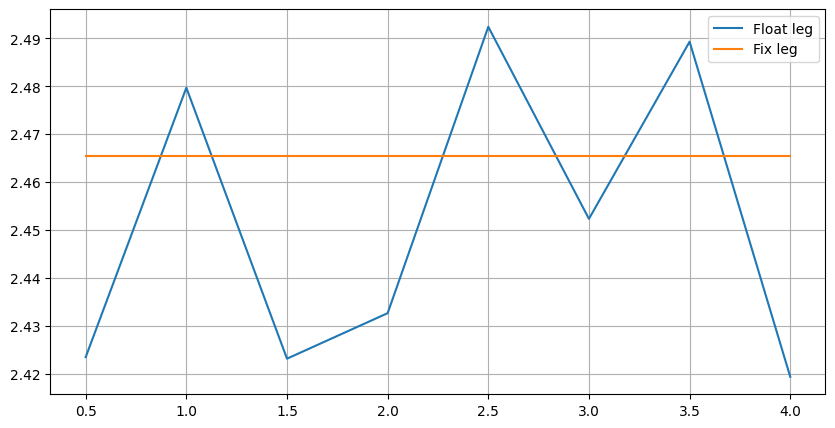

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(swap_df.index, swap_df.Float_leg, label='Float leg')
plt.plot(swap_df.index, swap_df.Fix_leg, label='Fix leg')
plt.legend()
plt.grid()
plt.show()

### Переоценка свопа - ставки упали


In [26]:
T = 2  ## новый срок до истечения контракта
start_rate = 4.43957 / 100


In [27]:
disc_rates_y = rates_y(T, start_time, freq, start_rate, step_rate)
disc_rates_y

OrderedDict([(0.5, 0.044395699999999996),
             (1.0, 0.044395699999999996),
             (1.5, 0.044395699999999996),
             (2.0, 0.044395699999999996)])

In [28]:
swap.set_rates(disc_rates_y)

In [29]:
swap.get_fix_rate()

OrderedDict([(0.5, 2.465429999999991),
             (1.0, 2.465429999999991),
             (1.5, 2.465429999999991),
             (2.0, 2.465429999999991),
             (2.5, 2.465429999999991),
             (3.0, 2.465429999999991),
             (3.5, 2.465429999999991),
             (4.0, 2.465429999999991)])

In [30]:
swap.get_fix_leg()

100.93038208904727

In [31]:
swap.get_float_leg()

100.0

In [32]:
swap.get_swap_value()

-0.9304

In [33]:
swap.get_forward_rates()

OrderedDict([(0.5, 0.044395699999999996),
             (1.0, 0.04439569999999993),
             (1.5, 0.04439569999999993),
             (2.0, 0.04439569999999993)])

In [34]:
swap.get_float_check()

100.0

### Переоценка свопа - ставки выросли


In [35]:
T = 1.5  ## новый срок до истечения контракта
start_rate = 5.36900 / 100


In [36]:
disc_rates_y = rates_y(T, start_time, freq, start_rate, step_rate)
disc_rates_y

OrderedDict([(0.5, 0.053689999999999995),
             (1.0, 0.053689999999999995),
             (1.5, 0.053689999999999995)])

In [37]:
swap.set_rates(disc_rates_y)

In [38]:
swap.get_fix_rate()

OrderedDict([(0.5, 2.465429999999991),
             (1.0, 2.465429999999991),
             (1.5, 2.465429999999991),
             (2.0, 2.465429999999991),
             (2.5, 2.465429999999991),
             (3.0, 2.465429999999991),
             (3.5, 2.465429999999991),
             (4.0, 2.465429999999991)])

In [39]:
swap.get_fix_leg()

99.37655813335441

In [40]:
swap.get_float_leg()

100.0

In [41]:
swap.get_swap_value()

0.6234

In [42]:
swap.get_forward_rates()

OrderedDict([(0.5, 0.053689999999999995),
             (1.0, 0.05368999999999979),
             (1.5, 0.05368999999999979)])

In [43]:
swap.get_float_check()

99.99999999999999

## 4. Currency swap (Валютный своп)


### Заключение своп-соглашения USD/JPY


In [44]:
T = 5  #срок


In [45]:
Ex_rate = 147.46  # обменный курс


### Валюта A
$USD$


In [46]:
N_A = 100
start_rate_A = 4.93086 / 100


In [47]:
disc_rates_A = rates_y(T, start_time, freq, start_rate_A, step_rate)


In [48]:
swap_A = Swap(N_A, freq, disc_rates_A)


In [49]:
swap_A.get_fix_rate()  ## купон


OrderedDict([(0.5, 2.4654299999999902),
             (1.0, 2.4654299999999902),
             (1.5, 2.4654299999999902),
             (2.0, 2.4654299999999902),
             (2.5, 2.4654299999999902),
             (3.0, 2.4654299999999902),
             (3.5, 2.4654299999999902),
             (4.0, 2.4654299999999902),
             (4.5, 2.4654299999999902),
             (5.0, 2.4654299999999902)])

In [50]:
swap_A.get_fix_leg()

100.0

### Валюта B
$JPY$

In [51]:
N_B = N_A * Ex_rate
start_rate_B = 0.03836 / 100


In [52]:
disc_rates_B = rates_y(T, start_time, freq, start_rate_B, step_rate)


In [53]:
swap_B = Swap(N_B, freq, disc_rates_B)


In [54]:
swap_B.get_fix_rate()  ## ставка свопа


OrderedDict([(0.5, 2.8282828000011495),
             (1.0, 2.8282828000011495),
             (1.5, 2.8282828000011495),
             (2.0, 2.8282828000011495),
             (2.5, 2.8282828000011495),
             (3.0, 2.8282828000011495),
             (3.5, 2.8282828000011495),
             (4.0, 2.8282828000011495),
             (4.5, 2.8282828000011495),
             (5.0, 2.8282828000011495)])

In [55]:
swap_B.get_fix_leg()

14746.0

### Оценка свопа через форвардные курсы


In [56]:
forward_er = forward_ex_rate(disc_rates_A, disc_rates_B, Ex_rate, freq)
forward_er

OrderedDict([(0.5, 143.93955388466142),
             (1.0, 140.5031545674444),
             (1.5, 137.14879552302708),
             (2.0, 133.87451812968376),
             (2.5, 130.6784105256388),
             (3.0, 127.55860649272407),
             (3.5, 124.51328436668776),
             (4.0, 121.5406659735184),
             (4.5, 118.63901559116294),
             (5.0, 115.80663893603271)])

In [57]:
coupon_B = swap_B.get_fix_rate()  ## ставка свопа


In [58]:
## Расчет ставок дисконтирования
l = []
for key in disc_rates_A:
    l.append(1 / (1 + disc_rates_A[key] / freq)**(freq * key))
disc_f_A = OrderedDict(zip(disc_rates_A.keys(), l))


In [59]:
sum([coupon_B[key] / forward_er[key] * disc_f_A[key]
     for key in coupon_B]) + N_B / forward_er[T] * disc_f_A[T]


100.0

### Переоценка валютного свопа


Переоценка валютного свопа связана с изменением процентных ставок в обеих странах, а также с измением валютного курса


In [60]:
T = 2.5  #новый срок


In [61]:
swap_reval = []
for r_d_delta in [-0.005, 0, 0.005]:
    rates_A = rates_y(T, start_time, freq, start_rate_A + r_d_delta, step_rate)
    swap_A.set_rates(rates_A)
    for r_f_delta in [-0.005, 0, 0.005]:
        rates_B = rates_y(T, start_time, freq, start_rate_B + r_f_delta,
                          step_rate)
        swap_B.set_rates(rates_B)
        for ex_r_delta in [-.1, 0, 0.1]:
            ex_rates = Ex_rate * (1 + ex_r_delta)
            reval = swap_A.get_fix_leg() - swap_B.get_fix_leg() / ex_rates
            swap_reval.append(
                [r_d_delta, r_f_delta, ex_r_delta,
                 np.round(reval, 4)])


In [62]:
swap_reval_df = pd.DataFrame(swap_reval)


In [63]:
swap_reval_df.columns = [
    'Change_domestic', 'Change_foreign', 'Change_ex_rate', 'Swap_reval'
]


In [64]:
swap_reval_df

,Change_domestic,Change_foreign,Change_ex_rate,Swap_reval
0,-0.005,-0.005,-0.1,-11.3386
1,-0.005,-0.005,0.0,-0.0877
2,-0.005,-0.005,0.1,9.1177
3,-0.005,0.000,-0.1,-9.9401
4,-0.005,0.000,0.0,1.1710
5,-0.005,0.000,0.1,10.2619
6,-0.005,0.005,-0.1,-8.5623
7,-0.005,0.005,0.0,2.4110
8,-0.005,0.005,0.1,11.3892
9,0.000,-0.005,-0.1,-12.5097


## 5.Валютный опцион


Для моделирования валютного опциона будем использовать формулу Garman–Kohlhagen (вариант формулы Блэка-Шоулза).

Класс, содержащий методы для моделирования валютного опциона:


In [65]:
class GK:

    def __init__(self, Spot, K, r_dom, r_for, T, sigma, t=0, is_call=True):
        self._Spot = Spot
        self._K = K
        self._r_dom = r_dom
        self._r_for = r_for
        self._T = T
        self._sigma = sigma
        self._t = t
        self._is_call = is_call

    def __d_values__(self):
        self._d1 = (np.log(self._Spot / self._K) +
                    (self._r_dom - self._r_for + 0.5 * self._sigma**2) *
                    (self._T - self._t)) / (self._sigma *
                                            np.sqrt(self._T - self._t))
        self._d2 = self._d1 - self._sigma * np.sqrt(self._T - self._t)

    def __N_d__(self, d_value):
        return stats.norm.cdf(d_value)

    def __price__(self):
        return (np.exp(-self._r_for*\
        (self._T-self._t))*self._Spot*self.__N_d__(self._d1)-np.exp(-self._r_dom*\
        (self._T-self._t))*self._K*self.__N_d__(self._d2)) if self._is_call \
        else (np.exp(-self._r_dom*(self._T-self._t))*self._K*self.__N_d__(-self._d2)- np.exp(-self._r_for*\
        (self._T-self._t))*self._Spot*self.__N_d__(-self._d1))

    def get_price(self):
        self.__d_values__()
        price = self.__price__()
        return price

    def get_delta(self):
        self.__d_values__()
        return self.__N_d__(
            self._d1) if self._is_call else self.__N_d__(self._d1) - 1

    def get_vega(self):
        self.__d_values__()
        return self._Spot*stats.norm.pdf(self._d1)*np.sqrt(self._T-self._t)*np.exp(-self._r_for*\
        (self._T-self._t))/100


Рассмотрим опцион USD/JPY с датой до экспирации через шесть месяцев.

Данные  взяты с сайта [Investing.com](https://www.investing.com/currencies/forex-options)

In [66]:
Spot = 147.45  ## спот-курс
K = 144.00  ## страйк
r_dom = 4.93086 / 100  ## ставка USD
r_for = 0.03836 / 100  ## ставка GBP
sigma = 12.14 / 100  ## волатильность
days = 180  ## дней до экспирации
T = days / 250  ## дней до экспирации в годах


In [67]:
GK(Spot, K, r_dom, r_for, T, sigma).get_price()


11.033010847907832

In [68]:
GK(Spot, K, r_dom, r_for, T, sigma).get_delta()


0.7334580490045051

In [69]:
GK(Spot, K, r_dom, r_for, T, sigma).get_vega()


0.41090116377358654

### Загрузка данных о процентных ставках


In [70]:
libor_option = pd.read_csv('https://github.com/qununc/financials_repo/blob/main/AppliedModels/ap_data/LIBOR_option_USD_JPY.csv?raw=true')

In [71]:
libor_option.dtypes

Term     object
USD     float64
JPY     float64
dtype: object

### Загрузка данных о рынке опционов, сайт www.investing.com


In [72]:
option = pd.read_csv('https://github.com/qununc/financials_repo/blob/844a415b14e37fc34d9ba59d471d8fb3641c8696/AppliedModels/ap_data/USD_JPY_option.csv?raw=true')
option.Put = option.Put * 100
option.Call = option.Call * 100


In [73]:
option

,Put_delta,Put,Strikes,Call,Call_delta,Imp_vol,Skew,Vega
0,-0.23,0.965,135.0,5.735,0.77,0.1052,0.0148,0.0021
1,-0.27,1.160,137.0,4.933,0.72,0.1021,0.0117,0.0022
2,-0.32,1.416,138.0,4.183,0.68,0.0991,0.0086,0.0024
3,-0.38,1.704,141.0,3.495,0.62,0.0962,0.0058,0.0025
4,-0.44,2.064,142.0,2.859,0.56,0.0936,0.0032,0.0026
5,-0.50,2.492,144.0,2.282,0.49,0.0913,0.0009,0.0026
6,-0.57,3.005,147.0,1.799,0.43,0.0893,-0.0011,0.0026
7,-0.64,3.574,148.0,1.371,0.36,0.0876,-0.0028,0.0024
8,-0.70,4.235,150.0,1.036,0.29,0.0861,-0.0043,0.0022
9,-0.76,4.958,153.0,0.752,0.24,0.0851,-0.0054,0.0021


In [74]:
option.dtypes

Put_delta     float64
Put           float64
Strikes       float64
Call          float64
Call_delta    float64
Imp_vol       float64
Skew          float64
Vega          float64
dtype: object

### Моделирование цен и показателей чувствительности опционов для серии страйков


In [75]:
option_GK = option[['Strikes', 'Imp_vol']]


In [76]:
Spot = 147.46
days = 180
T = days / 250


In [77]:
option_GK['Call'] = option.apply(lambda row: GK(Spot, row[
    'Strikes'], libor_option.iloc[2, 1] / 100, libor_option.iloc[2, 2] / 100,
                                                T, row['Imp_vol']).get_price(),
                                 axis=1)


In [78]:
option_GK['Call_delta'] = option.apply(lambda row: GK(
    Spot, row['Strikes'], libor_option.iloc[2, 1] / 100, libor_option.iloc[
        2, 2] / 100, T, row['Imp_vol']).get_delta(),
                                       axis=1)


In [79]:
option_GK['Put'] = option.apply(lambda row: GK(Spot,
                                               row['Strikes'],
                                               libor_option.iloc[2, 1] / 100,
                                               libor_option.iloc[2, 2] / 100,
                                               T,
                                               row['Imp_vol'],
                                               is_call=False).get_price(),
                                axis=1)


In [80]:
option_GK['Put_delta'] = option.apply(
    lambda row: GK(Spot,
                   row['Strikes'],
                   libor_option.iloc[2, 1] / 100,
                   libor_option.iloc[2, 2] / 100,
                   T,
                   row['Imp_vol'],
                   is_call=False).get_delta(),
    axis=1)


In [81]:
option_GK['Vega'] = option.apply(lambda row: GK(Spot,
                                                row['Strikes'],
                                                libor_option.iloc[2, 1] / 100,
                                                libor_option.iloc[2, 2] / 100,
                                                T,
                                                row['Imp_vol'],
                                                is_call=False).get_vega(),
                                 axis=1
                                 )


In [82]:
option_GK

,Strikes,Imp_vol,Call,Call_delta,Put,Put_delta,Vega
0,135.0,0.1052,13.672010,0.852480,1.043542,-0.147520,0.288638
1,137.0,0.1021,11.951388,0.817665,1.321427,-0.182335,0.331139
2,138.0,0.0991,11.064523,0.800909,1.433816,-0.199091,0.349501
3,141.0,0.0962,8.737290,0.727204,2.104343,-0.272796,0.416037
4,142.0,0.0936,7.940479,0.701926,2.306786,-0.298074,0.433976
5,144.0,0.0913,6.551177,0.640870,2.915991,-0.359130,0.467934
6,147.0,0.0893,4.774928,0.537855,4.137503,-0.462145,0.497152
7,148.0,0.0876,4.200577,0.501680,4.562405,-0.498320,0.499397
8,150.0,0.0861,3.254934,0.428289,5.615270,-0.571711,0.491312
9,153.0,0.0851,2.164295,0.323496,7.522391,-0.676504,0.449688


## 6. Стратегия risk-riversal


Стратегия состоит в одновременной покупке опциона колл и продаже опциона пут со страйками вне денег


In [83]:
Strike_call = 144. + 0.51
Strike_put = 144. - 0.47


In [84]:
risk_reversal_setup=pd.DataFrame(zip(['Call','Put'],[Strike_call,Strike_put],
                                     [GK(Spot,Strike_call,libor_option.iloc[2,1]/100,libor_option.iloc[2,2]/100,T,option.iloc[5,5]).get_price(),\
GK(Spot,Strike_put,libor_option.iloc[2,1]/100,libor_option.iloc[2,2]/100,T,option.iloc[5,5]).get_price()],['Buy','Sell']),\
                               columns=['Type','Strike','Price','Buy/Sell'])

In [85]:
risk_reversal_setup

,Type,Strike,Price,Buy/Sell
0,Call,144.51,6.244006,Buy
1,Put,143.53,6.842162,Sell


In [86]:
risk_reversal_result=pd.DataFrame(zip(np.arange(1.20,1.40,.01),np.maximum(np.arange(1.20,1.40,.01)-risk_reversal_setup.iloc[0,1],0)-risk_reversal_setup.iloc[0,2],\
-np.maximum(risk_reversal_setup.iloc[1,1]-(np.arange(1.20,1.40,.01)),0)+risk_reversal_setup.iloc[1,2]),columns=['Spot','Call','Put'])

In [87]:
risk_reversal_result[
    'Result'] = risk_reversal_result['Call'] + risk_reversal_result['Put']


In [88]:
risk_reversal_result

,Spot,Call,Put,Result
0,1.20,-6.244006,-135.487838,-141.731844
1,1.21,-6.244006,-135.477838,-141.721844
2,1.22,-6.244006,-135.467838,-141.711844
3,1.23,-6.244006,-135.457838,-141.701844
4,1.24,-6.244006,-135.447838,-141.691844
5,1.25,-6.244006,-135.437838,-141.681844
6,1.26,-6.244006,-135.427838,-141.671844
7,1.27,-6.244006,-135.417838,-141.661844
8,1.28,-6.244006,-135.407838,-141.651844
9,1.29,-6.244006,-135.397838,-141.641844


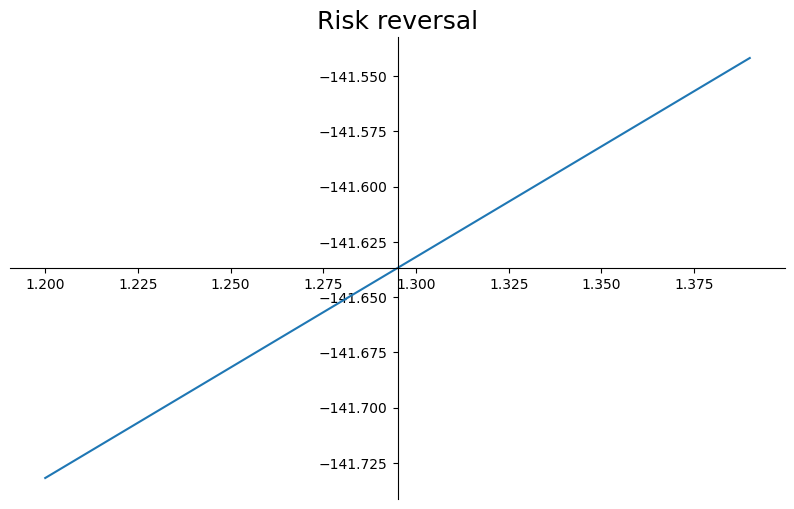

In [89]:
fig = plt.figure(figsize=(10, 6))
plt.plot(risk_reversal_result.Spot, risk_reversal_result.Result)
ax = plt.gca()
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.yaxis.set_ticks_position('left')
_ = plt.title('Risk reversal', fontsize=18)


# Выводы:


1. Построена модель процентного свопа, за основу процентные ставки для USD.
2. Построена модель валютного свопа, за основу взяты процентные ставки для двух валют -- USD и JPY --  и их валютный курс.
3. Построена модель валютного опциона, за основу взята валютная пара USD/JPY.
4. Смоделирована стратегия risk-reversal.
